In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime

#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/joshuakeeling/Documents/Python/Project/line_loop/packages/")

In [2]:
import mouse_poker as mpk
from mouse_poker.navi import *

In [3]:
#This one for 3:
#root = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_3NAVI/'
#file = "'456675_10'-2021-02-23-102809.txt"
#file = "'456675_10'-2021-03-04-105905.txt"
#file = "'460175_10'-2021-03-02-142443.txt"

#This one for 4:
root = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_4_RUNNAVI/'
#file = "'456675_3'-2021-02-12-121633.txt"
file = "'456675_3'-2021-03-02-103339.txt"

fpath = os.path.join(root,file)
f = open(fpath)
lines = f.readlines()

#Get metadata:
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,\
    test,overview = mpk.load.get_metadata(lines)

state_seq,rew_list,port_seq,forced_seq = extract_navi_dat(lines)

overview

{'task_nr': 2,
 'reward_volume': 2,
 'reward_absorbP': 0,
 'click_volume': 30,
 'setup_number': 1,
 'subject_id': '456675_3',
 'probe_duration': 2000,
 'probe_frequency': 0,
 'wrong_dur': 20,
 'reward_probability': 1,
 'timeout_dur': 2000,
 'req_poke_dur': 20,
 'n_rewards': 248,
 'graph_type': 'line',
 'multiple_wrong_in_row': False,
 'lit_pokes': 1515.0,
 'dark_pokes': 670.0,
 'max_repeat_transition': 0,
 'nStates': 9,
 'stop_reward_consumption_dur': 50,
 'repeat_2': 1,
 'ITI_duration': 2000,
 'reward_counter': 8,
 'n_till_guide': 15}

In [4]:
##The logic:
#Find the state being rewarded during each step in the session
#If the choice that is made decreases the step distance from rew
#score choice as correct if not, score as incorrect

def create_useful_arrs(state_seq,port_seq,rew_list,forced_seq):
    
    ##Need to end the used data with the final reward rather than 
    #half way through a trial
    final = np.where(rew_list)[0][-1]+1
    state_seq = state_seq[0:final]
    rew_list = rew_list[0:final]
    port_seq = port_seq[0:final]
    forced_seq = forced_seq[0:final]
    
    ##Create array of state being rewarded during each step in the session
    rew_state = np.zeros(len(rew_list))
    xx = 0
    for i in np.where(rew_list)[0]:
        rew_state[xx:i+1]=state_seq[i]
        xx = i+1

    #Whether the choice is correct:
    choice_list = np.zeros(len(rew_list))

    for ii in np.arange(len(state_seq)):
        if rew_list[ii] is True:
            choice_list[ii] = 'Nan' #Score the reward state "choice" as Nan
        else:
            d0 = np.abs(state_seq[ii]-rew_state[ii])
            d1 = np.abs(state_seq[ii+1]-rew_state[ii+1])
            if d1 - d0 == -1:
                #correct choice gets score of 1
                choice_list[ii]=1
            else:
                #incorrect choice gets score of 0
                choice_list[ii]=0
                
    ##Arr for indices of reward changes
    rew_change = np.where(rew_state[:-1] != rew_state[1:])[0]
    #Ensure analysis of final section
    rew_change_end = np.append(rew_change, len(rew_list)-1)
    
    ## Arr of perf with each successive trial
    # trial_perf
    ARR = np.where(rew_list)[0]
    trial_perf = [] #Arr w perf on each trial scored as above
    z = -1
    low = 0

    for i in rew_change_end:
        for ii in np.where((ARR>z) & (ARR<=i))[0]:
            upp = int(ARR[ii])
            y = np.nanmean(choice_list[low:upp])
            low = int(ARR[ii])
            trial_perf.append(y)
        z = i

    ##Create arr for trial# where rew change
    # trial_rew_change_end
    trial_rew_change_end = np.zeros(len(rew_change_end))
    for i in np.arange(len(rew_change_end)):
        y = np.where(np.where(rew_list)[0]==rew_change_end[i])[0]
        trial_rew_change_end[i] = y 
    
    
    return state_seq,rew_list,port_seq,forced_seq,rew_state,choice_list,\
rew_change,rew_change_end,trial_perf,trial_rew_change_end

In [5]:
state_seq,rew_list,port_seq,forced_seq,rew_state,choice_list,\
rew_change,rew_change_end,trial_perf,trial_rew_change_end \
= create_useful_arrs(state_seq,port_seq,rew_list,forced_seq)

In [6]:
z = 0
print("Mean perf in each rew location")
for i in rew_change_end:
    y = np.nanmean(choice_list[z:i-1])
    z = i-1
    print(rew_state[i-1], int(y*100))
    
print("\nDoes perf imprv with succ trials with rew at same loc??")
NM = 10 #arbitrary number of sections to take mean of
low = 0
arr = np.linspace(rew_change[0],rew_change_end[1],num=NM)

for i in np.arange(NM):
    upp = arr[i]
    y = np.nanmean(choice_list[int(low):int(upp)])
    low = arr[i]
    print(int(y*100))

Mean perf in each rew location
1.0 83
7.0 68
3.0 94
5.0 78
3.0 87
1.0 76
3.0 88
1.0 90
5.0 77
3.0 90
7.0 64

Does perf imprv with succ trials with rew at same loc??
83
60
60
53
82
60
75
75
73
75


Plot perf in first set of rewards


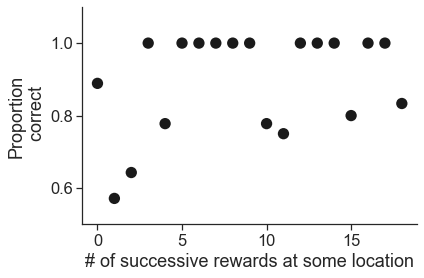

In [7]:
print("Plot perf in first set of rewards")
x = range(int(trial_rew_change_end[0]-1))
y = trial_perf[0:int(trial_rew_change_end[0])-1]

plt.scatter(x, y,color='k',s=128,edgecolors='none')
plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion\n correct")
plt.ylim(.5,1.1)
seaborn.despine()

Plot perf for each section of reward location


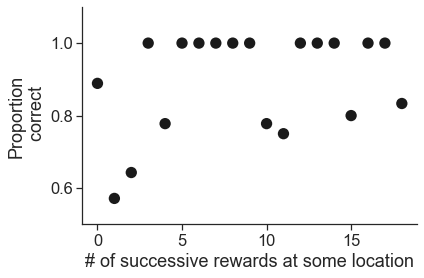

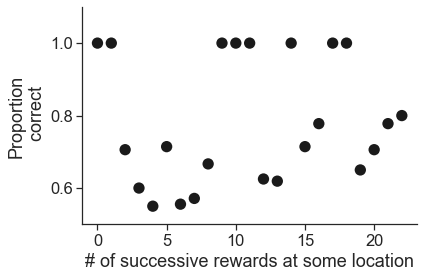

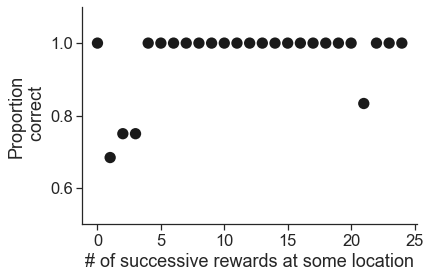

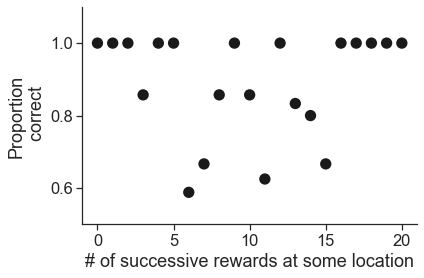

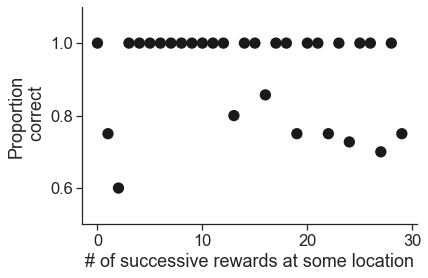

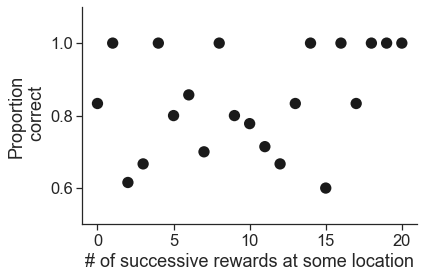

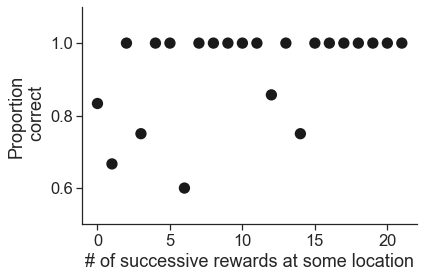

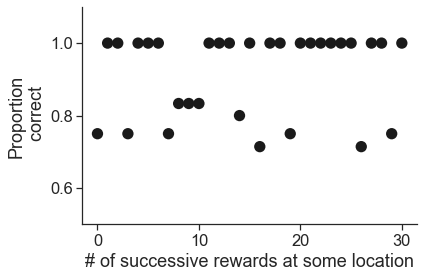

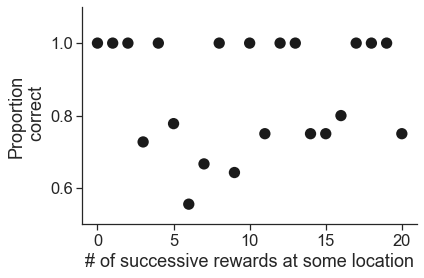

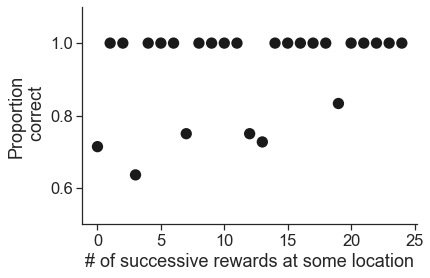

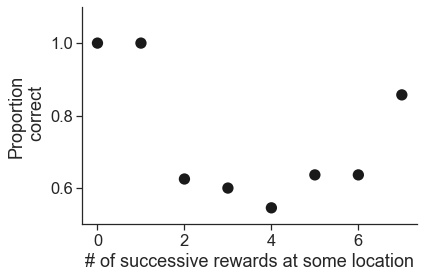

In [8]:
print("Plot perf for each section of reward location")
low = 0
for i in np.arange(len(trial_rew_change_end)):
    upp = int(trial_rew_change_end[i]-1)
    x = np.arange(upp-low)
    y = trial_perf[low:upp]
    low = upp
    
    plt.scatter(x, y,color='k',s=128,edgecolors='none')
    plt.xlabel("# of successive rewards at some location")
    plt.ylabel("Proportion\n correct")
    plt.ylim(.5,1.1)
    seaborn.despine()
    plt.show()